# Density Estimation Using Real NVP Tutorial

The basic idea behind Real NVP is to constructs a transformation/flow between latent variables and observed variables such that the transformation satisfies the following two conditions:

1. It is invertible and its Jacobian matrix's determinant is easy to compute.
2. It is flexible such that it can transform random variables of simple distributions into random variables of complex distributions.

First, we import the required modules for our functions:

In [1]:
import numpy as np
import pickle
import math
from sys import exit
import matplotlib.pyplot as plt
from sklearn import datasets
import argparse

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as functional

torch.set_default_dtype(torch.float64) #use double precision numbers

The transformation used in the real NVP method is a composition of multiple affine coupling transformations. In each affine coupling transformation, a subset of the random varaibles is kept the same and an affine transformation, parameterized using the fixed random varaibles, is applied to the remaining subset of the random variables. It is staightforward to show that the affine coupling transformation satifies the above two conditions. 

In [2]:
class Affine_Coupling(nn.Module):
    def __init__(self, mask, hidden_dim):
        super(Affine_Coupling, self).__init__()
        self.input_dim = len(mask)
        self.hidden_dim = hidden_dim

        ## mask to seperate positions that do not change and positions that change.
        ## mask[i] = 1 means the ith position does not change.
        self.mask = nn.Parameter(mask, requires_grad = False)

        ## layers used to compute scale in affine transformation
        self.scale_fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.scale_fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.scale_fc3 = nn.Linear(self.hidden_dim, self.input_dim)
        self.scale = nn.Parameter(torch.Tensor(self.input_dim))
        init.normal_(self.scale)

        ## layers used to compute translation in affine transformation 
        self.translation_fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.translation_fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.translation_fc3 = nn.Linear(self.hidden_dim, self.input_dim)

    def _compute_scale(self, x):
        ## compute scaling factor using unchanged part of x with a neural network
        s = torch.relu(self.scale_fc1(x*self.mask))
        s = torch.relu(self.scale_fc2(s))
        s = torch.relu(self.scale_fc3(s)) * self.scale        
        return s

    def _compute_translation(self, x):
        ## compute translation using unchanged part of x with a neural network        
        t = torch.relu(self.translation_fc1(x*self.mask))
        t = torch.relu(self.translation_fc2(t))
        t = self.translation_fc3(t)        
        return t
    
    def forward(self, x):
        ## convert latent space variable to observed variable
        s = self._compute_scale(x)
        t = self._compute_translation(x)
        
        y = self.mask*x + (1-self.mask)*(x*torch.exp(s) + t)        
        logdet = torch.sum((1 - self.mask)*s, -1)
        
        return y, logdet

    def inverse(self, y):
        ## convert observed varible to latent space variable
        s = self._compute_scale(y)
        t = self._compute_translation(y)
                
        x = self.mask*y + (1-self.mask)*((y - t)*torch.exp(-s))
        logdet = torch.sum((1 - self.mask)*(-s), -1)
        
        return x, logdet

The real NVP method can be applied to train models for estimating density in two different scenarios. In the first scenario, samples/data from the underlying distribution are available and we want to train a model to estimate the underlying distribution density. In the second scenario, we know the unnormalized distribution density function and do not know its normalization factor. In this case, we want to train a model such that samples from the trained model approximate the unnormalized distribution density. In the following, the real NVP method is applied to train models in both scenarios. To make things simple, the distributions shown here are only two dimensional distributions, but similar ideas can be applied to high dimensional distributions.

In [3]:
class RealNVP_2D(nn.Module):
    '''
    A vanilla RealNVP class for modeling 2 dimensional distributions
    '''
    def __init__(self, masks, hidden_dim):
        '''
        initialized with a list of masks. each mask define an affine coupling layer
        '''
        super(RealNVP_2D, self).__init__()        
        self.hidden_dim = hidden_dim        
        self.masks = nn.ParameterList(
            [nn.Parameter(torch.Tensor(m),requires_grad = False)
             for m in masks])

        self.affine_couplings = nn.ModuleList(
            [Affine_Coupling(self.masks[i], self.hidden_dim)
             for i in range(len(self.masks))])
        
    def forward(self, x):
        ## convert latent space variables into observed variables
        y = x
        logdet_tot = 0
        for i in range(len(self.affine_couplings)):
            y, logdet = self.affine_couplings[i](y)
            logdet_tot = logdet_tot + logdet

        ## a normalization layer is added such that the observed variables is within
        ## the range of [-4, 4].
        logdet = torch.sum(torch.log(torch.abs(4*(1-(torch.tanh(y))**2))), -1)        
        y = 4*torch.tanh(y)
        logdet_tot = logdet_tot + logdet
        
        return y, logdet_tot

    def inverse(self, y):
        ## convert observed variables into latent space variables        
        x = y        
        logdet_tot = 0

        # inverse the normalization layer
        logdet = torch.sum(torch.log(torch.abs(1.0/4.0* 1/(1-(x/4)**2))), -1)
        x  = 0.5*torch.log((1+x/4)/(1-x/4))
        logdet_tot = logdet_tot + logdet

        ## inverse affine coupling layers
        for i in range(len(self.affine_couplings)-1, -1, -1):
            x, logdet = self.affine_couplings[i].inverse(x)
            logdet_tot = logdet_tot + logdet
            
        return x, logdet_tot

## 1. Train models with the real NVP method using samples.

Here, we use our real NVP method to train a model based on samples from the moon dataset.

idx_steps: 999, loss: 1.00833
idx_steps: 1999, loss: 0.68875
idx_steps: 2999, loss: 0.62829
idx_steps: 3999, loss: 0.51162
idx_steps: 4999, loss: 0.50178


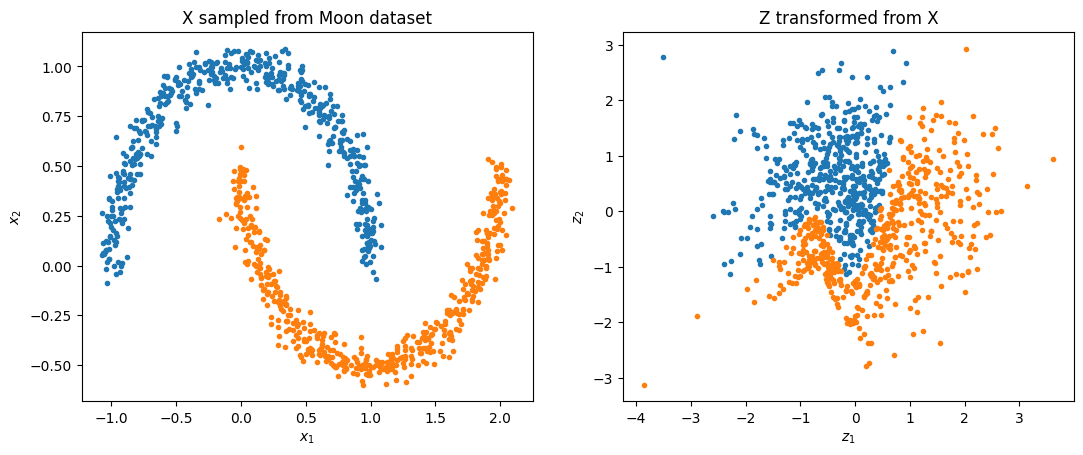

In [4]:
## Masks used to define the number and the type of affine coupling layers
## In each mask, 1 means that the variable at the correspoding position is
## kept fixed in the affine couling layer
masks = [[1.0, 0.0],
         [0.0, 1.0],
         [1.0, 0.0],         
         [0.0, 1.0],
         [1.0, 0.0],         
         [0.0, 1.0],
         [1.0, 0.0],
         [0.0, 1.0]]

## dimenstion of hidden units used in scale and translation transformation
hidden_dim = 64

## construct the RealNVP_2D object
realNVP = RealNVP_2D(masks, hidden_dim)
if torch.cuda.device_count():
    realNVP = realNVP.cuda()
device = next(realNVP.parameters()).device

optimizer = optim.Adam(realNVP.parameters(), lr = 0.0001)

num_steps = 5000
# num_steps = 5000

## the following loop learns the RealNVP_2D model by data
## in each loop, data is dynamically sampled from the scipy moon dataset
for idx_step in range(num_steps):
    ## sample data from the scipy moon dataset
    X, label = datasets.make_moons(n_samples = 512, noise = 0.05)
    X = torch.Tensor(X).to(device = device)

    ## transform data X to latent space Z
    z, logdet = realNVP.inverse(X)

    ## calculate the negative loglikelihood of X
    loss = torch.log(z.new_tensor([2*math.pi])) + torch.mean(torch.sum(0.5*z**2, -1) - logdet)
    
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

    if (idx_step + 1) % 1000 == 0:
        print(f"idx_steps: {idx_step:}, loss: {loss.item():.5f}")
        
## after learning, we can test if the model can transform
## the moon data distribution into the normal distribution
X, label = datasets.make_moons(n_samples = 1000, noise = 0.05)
X = torch.Tensor(X).to(device = device)
z, logdet_jacobian = realNVP.inverse(X)
z = z.cpu().detach().numpy()

X = X.cpu().detach().numpy()
fig = plt.figure(2, figsize = (12.8, 4.8))
fig.clf()
plt.subplot(1,2,1)
plt.plot(X[label==0,0], X[label==0,1], ".")
plt.plot(X[label==1,0], X[label==1,1], ".")
plt.title("X sampled from Moon dataset")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

plt.subplot(1,2,2)
plt.plot(z[label==0,0], z[label==0,1], ".")
plt.plot(z[label==1,0], z[label==1,1], ".")
plt.title("Z transformed from X")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
plt.show()

Samples from the moon dataset, shown in the left of the following figure, are used to train a model with the real NVP method. After the training, these samples can be transformed into samples of standard normal distribution shown on the right.

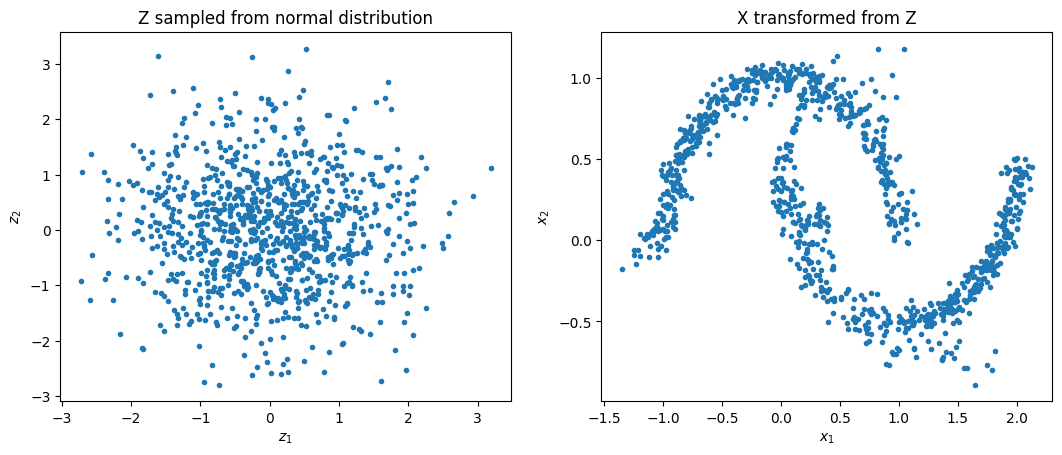

In [5]:
## after learning, we can also test if the model can transform
## the normal distribution into the moon data distribution 
z = torch.normal(0, 1, size = (1000, 2)).to(device = device)
X, _ = realNVP(z)
X = X.cpu().detach().numpy()
z = z.cpu().detach().numpy()

fig = plt.figure(2, figsize = (12.8, 4.8))
fig.clf()
plt.subplot(1,2,1)
plt.plot(z[:,0], z[:,1], ".")
plt.title("Z sampled from normal distribution")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")

plt.subplot(1,2,2)
plt.plot(X[:,0], X[:,1], ".")
plt.title("X transformed from Z")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

plt.show()

The corresponding inverse transformation can transform samples of standard normal distributions into samples of the moon dataset distribution as shown in the following figure. The left figure shows samples from a standard normal distribution and the right figure shows the transformed samples.

## 2. Train models with the real NVP method using potential energy.

Here is just one of the models trained to approximate potential energies. In the training, only the potential energy functions are used. This potential energy functions are from the normalizing flow paper. 

In [ ]:
# pass an index to specify which potential to use
# Here we just set potential_index = 1 to study the first graph

#parser = argparse.ArgumentParser()
#parser.add_argument("--potential_index", type = int, choices = range(1,5), required = True)
#args = parser.parse_args()

potential_index = 1
U = [compute_U1, compute_U2, compute_U3, compute_U4]
compute_U = U[potential_index - 1]

## Masks used to define the number and the type of affine coupling layers
## In each mask, 1 means that the variable at the correspoding position is
## kept fixed in the affine couling layer
masks = [[1.0, 0.0],
         [0.0, 1.0],
         [1.0, 0.0],         
         [0.0, 1.0],
         [1.0, 0.0],         
         [0.0, 1.0],
         [1.0, 0.0],
         [0.0, 1.0]]

## dimenstion of hidden units used in scale and translation transformation
hidden_dim = 128

## construct the RealNVP_2D object
realNVP = RealNVP_2D(masks, hidden_dim)
if torch.cuda.device_count():
    realNVP = realNVP.cuda()
    
optimizer = optim.Adam(realNVP.parameters(), lr = 0.0001)
num_steps = 5000 #you can adjust num_steps as nessesary

## the following loop learns the RealNVP_2D model by potential energy
## defined in the ./script/functions.py
for idx_step in range(num_steps):
    Z = torch.normal(0, 1, size = (1024, 2))
    Z = Z.cpu() #change this to cuda if available
    X, logdet = realNVP(Z)

    logp = -compute_U(X)
    loss = torch.mean(-logdet - logp)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (idx_step + 1) % 1000 == 0:
        print(f"idx_steps: {idx_step:}, loss: {loss.item():.5f}")

z = torch.normal(0, 1, size = (1000, 2))
z = z.cpu()
x, _ = realNVP(z)
x = x.cpu().detach().numpy()
z = z.cpu().detach().numpy()
   
fig = plt.figure(0)
fig.clf()
plt.plot(x[:,0], x[:,1], ".")
plt.xlabel(r'$X_1$')
plt.ylabel(r'$X_2$')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.show()

After training models, we can generate samples from the model by transforming samples of standard normal distribution. These samples are shown in the above figure.